In [1]:
%pylab inline
import ThonkTools as TT
from uncertainties import ufloat
from scipy import interpolate
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Daten einlesen
def read (path,offset=2, *kwargs):
    from numpy import array as array
    doc = []
    with open (path, 'r') as myfile:
        data = myfile.read().replace(',', '.').replace('\n', ',').replace('  ', ',').replace("\t",",")
        datarray = data.split(',')
        output = []
    for item in datarray:
        if item != '':
            output.append(int(item))
    dataset = array(output[offset:])
    dataset = [array(range(len(dataset))), dataset]
    return dataset

In [3]:
am_1 = read("Am_2_2.TKA")
am_2 = read("Am_1.TKA")
am_1_1 = am_1[0]
am_1_2 = am_1[1]
am_2_1 = am_2[0]
am_2_2 = am_2[1]

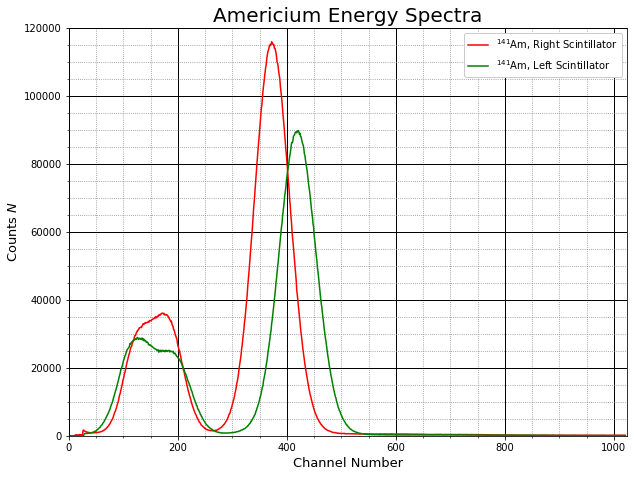

In [4]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

plt.plot(am_1_1,am_1_2, color='red', label=r'$^{141}$Am, Right Scintillator ')
plt.plot(am_2_1,am_2_2, color='green', label=r'$^{141}$Am, Left Scintillator ')

###   Label / Title

plt.ylabel(r'Counts $N$', fontsize=13)
plt.xlabel(r'Channel Number', fontsize=13)
plt.title('Americium Energy Spectra', fontsize=20)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

axes.set_xlim([0,1024])
axes.set_ylim([0,120000])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend(framealpha=1)
#plt.savefig('Americium_Energy_Spectra.png')
plt.show()

# Einzelne Peaks

In [5]:
#Thonk Tools Fit Funktionen
def fit_pm(x, y, func=lambda x: x, p0=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2

def fit(x, y, func=lambda x: x, p0=None, r=None, d=None):
    """
        fit takes data points, calculates the curve fit, and gives back
        the values with which the curve can be plotted
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: the function type the curve_fit will be applied to.
        r: determines the size of steps in which the x-achse intervall is split.
        d: tuple which determines the start and end point of the x-achse intervall on which the
            will be drawn. If not given the curve will be drawn between the largest and the smalest
            given x-value.
        Returns:
        -----------
        xnew: x-value with which the fitted curve can be plotted.
        ynew: y-value with which the fitted curve can be plotted.
    """
    import numpy as np
    from scipy.optimize import curve_fit
    popt, pvoc = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    if d == None:
        if r == None:
            xnew = np.arange(min(x), max(x), np.abs((max(x) - min(x)) / 100))
        else:
            xnew = np.arange(min(x), max(x), r)
    else:
        if r == None:
            xnew = np.arange(min(d), max(d), np.abs((max(x) - min(x)) / 100))
        else:
            xnew = np.arange(min(d), max(d), r)
    ynew = func(xnew, *params)
    return xnew, ynew

In [6]:
#Funktionen für Dopple Gauß TT.fit/TT.fit_pm (aus dem Packet)
def gaus2fit(x, y, p0=None, r=None, d=None):
    import numpy as np
    return TT.fit(x, y, func=lambda x, mu, sigma, A, mu2, sigma2, B2, A2: A2 * np.e ** ((-1 * (x - mu2) ** 2) / (2 * sigma2 ** 2)) + B2 + A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)), r=r,
               d=d, p0=p0)
def gaus2fit_pm(x, y, p0=None):
    import numpy as np
    return TT.fit_pm(x, y, func=lambda x, mu, sigma, A, mu2, sigma2, B2, A2: A2 * np.e ** ((-1 * (x - mu2) ** 2) / (2 * sigma2 ** 2)) + B2 + A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)), p0=p0)

In [7]:
Guess=[125,1,30000,185,1,1,35000] #Schätzung der Werte


#Gesammter Fit
gaus2_1 = gaus2fit(am_1_1[0:250], am_1_2[0:250], Guess, r=0.5, d=None)


#Einzelne Peaks
gaus2_1_value, gaus2_1_error ,R2 = gaus2fit_pm(am_1_1[0:250], am_1_2[0:250], Guess) #Berechnung der Parameter
mu, sigma, A, mu2, sigma2, B2, A2= gaus2_1_value #Liste der Parameter
xgaus = np.arange(0,250,0.5) 
ygaus1 = A * np.e ** ((-1 * (xgaus - mu) ** 2) / (2 * sigma ** 2)) + B2 #Parameter des 1.Peaks
ygaus2 = A2 * np.e ** ((-1 * (xgaus - mu2) ** 2) / (2 * sigma2 ** 2)) + B2 #Parameter des 2.Peaks

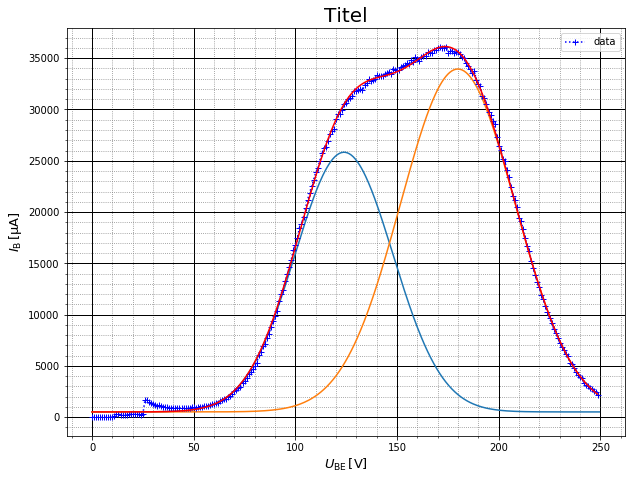

In [8]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot


plt.plot(xgaus, ygaus1)
plt.plot(xgaus, ygaus2)
plt.plot(am_1_1[0:250], am_1_2[0:250],'b+:',label='data')
plt.plot(gaus2_1[0], gaus2_1[1], color='red')

###   Label / Title

plt.xlabel(r'$U_\mathrm{BE}\,[\mathrm{V}]$', fontsize=13)
plt.ylabel(r'$I_\mathrm{B}\,[\mathrm{µA}]$', fontsize=13)
plt.title('Titel', fontsize=20)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([0,0.8])
#axes.set_ylim([-1,110])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend()
#plt.savefig('Dateiname.png')
plt.show()

In [9]:
Guess=[125,1,28000,175,1,1,25000] #Schätzung der Werte


#Gesammter Fit
gaus2_2 = gaus2fit(am_2_1[0:250], am_2_2[0:250], Guess, r=0.5, d=None)


#Einzelne Peaks
gaus2_2_value, gaus2_2_error ,R2 = gaus2fit_pm(am_2_1[0:250], am_2_2[0:250], Guess) #Berechnung der Parameter
mu, sigma, A, mu2, sigma2, B2, A2= gaus2_2_value #Liste der Parameter
xgaus = np.arange(0,250,0.5) 
ygaus1_2 = A * np.e ** ((-1 * (xgaus - mu) ** 2) / (2 * sigma ** 2)) + B2 #Parameter des 1.Peaks
ygaus2_2 = A2 * np.e ** ((-1 * (xgaus - mu2) ** 2) / (2 * sigma2 ** 2)) + B2 #Parameter des 2.Peaks

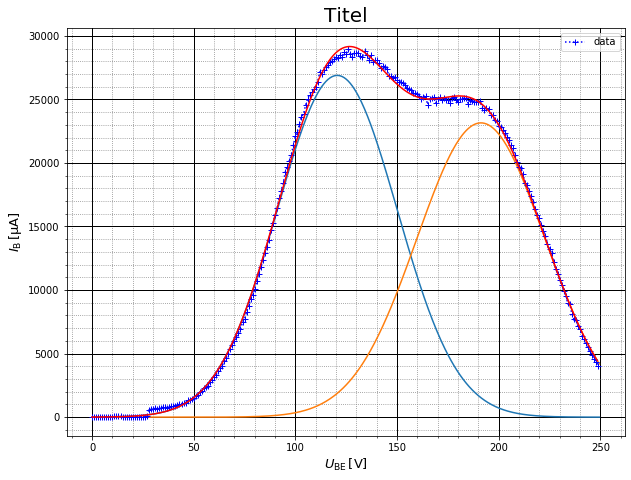

In [11]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot


plt.plot(xgaus, ygaus1_2)
plt.plot(xgaus, ygaus2_2)
plt.plot(am_2_1[0:250], am_2_2[0:250],'b+:',label='data')
plt.plot(gaus2_2[0], gaus2_2[1], color='red')

###   Label / Title

plt.xlabel(r'$U_\mathrm{BE}\,[\mathrm{V}]$', fontsize=13)
plt.ylabel(r'$I_\mathrm{B}\,[\mathrm{µA}]$', fontsize=13)
plt.title('Titel', fontsize=20)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([0,0.8])
#axes.set_ylim([-1,110])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend()
#plt.savefig('Dateiname.png')
plt.show()